# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Importamos los datos

In [4]:
path = '../../../Base de datos/Trayectorias 200 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')
varftrain = np.transpose(varftrain, (0,3,1,2))

In [6]:
np.shape(varftrain)

(7000, 200, 10, 2)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')
varftest = np.transpose(varftest, (0,3,1,2))

In [10]:
np.shape(varftest)

(2000, 200, 10, 2)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')
varfval = np.transpose(varfval, (0,3,1,2))

In [14]:
np.shape(varfval)

(1000, 200, 10, 2)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(200, 10, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [3]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [4]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(200, (5, 1), activation='tanh', input_shape=(200, 10, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Segunda capa convolucional
model.add(Conv2D(49, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Tercera capa convolucional
model.add(Conv2D(24, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Cuarta capa convolucional
model.add(Conv2D(100, (5, 2), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Aplanamos la entrada
model.add(Flatten())

#Capas densas
model.add(Dense(200, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(100, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(50,activation = 'relu', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 10, 50)       550       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 10, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 10, 49)        12299     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 10, 49)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 10, 24)        5904      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 10, 24)       0

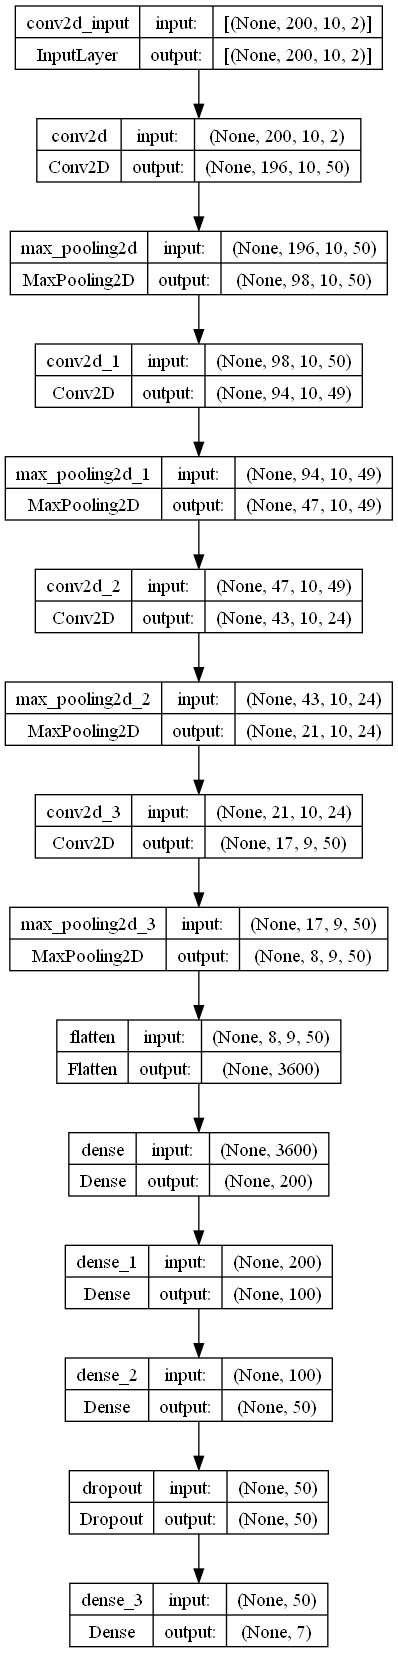

In [6]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [28]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=10.0)

In [29]:
model.compile(optimizer= optimizer,
              loss= 'MSE',
              metrics=['mae'])

In [30]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [31]:
val_epochs = 1000
tf.compat.v1.global_variables_initializer()

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 4s 6ms/step - loss: 6.9051 - mae: 1.8811 - val_loss: 6.7110 - val_mae: 1.8276 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 4s 6ms/step - loss: 6.7418 - mae: 1.8617 - val_loss: 6.2309 - val_mae: 1.7515 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 4s 5ms/step - loss: 6.7009 - mae: 1.8572 - val_loss: 6.2437 - val_mae: 1.7779 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 4s 6ms/step - loss: 6.7121 - mae: 1.8498 - val_loss: 6.4147 - val_mae: 1.8088 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 4s 5ms/step - loss: 6.4108 - mae: 1.8229 - val_loss: 6.2322 - val_mae: 1.7496 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 4s 5ms/step - loss: 6.6147 - mae: 1.8285 - val_loss: 6.1206 - val_mae: 1.7314 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 4s 5ms/step - loss: 6.5790 - mae: 1.8242 - val_loss: 6.2204 - 

700/700 [==============================] - 4s 5ms/step - loss: 6.1975 - mae: 1.6850 - val_loss: 6.2583 - val_mae: 1.6190 - lr: 0.0010
Epoch 112/1000
700/700 [==============================] - 4s 5ms/step - loss: 6.2789 - mae: 1.6904 - val_loss: 5.5277 - val_mae: 1.5852 - lr: 0.0010
Epoch 113/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.5777 - mae: 1.6374 - val_loss: 5.2403 - val_mae: 1.5602 - lr: 0.0010
Epoch 114/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.6114 - mae: 1.6436 - val_loss: 5.4859 - val_mae: 1.6192 - lr: 0.0010
Epoch 115/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.8748 - mae: 1.6619 - val_loss: 5.6011 - val_mae: 1.5877 - lr: 0.0010
Epoch 116/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.6555 - mae: 1.6367 - val_loss: 5.1925 - val_mae: 1.5419 - lr: 0.0010
Epoch 117/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.6306 - mae: 1.6414 - val_loss: 5.4740 - v

700/700 [==============================] - 4s 5ms/step - loss: 6.1099 - mae: 1.6680 - val_loss: 5.4428 - val_mae: 1.5680 - lr: 0.0010
Epoch 167/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.7524 - mae: 1.6523 - val_loss: 5.3942 - val_mae: 1.5708 - lr: 0.0010
Epoch 168/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.8182 - mae: 1.6515 - val_loss: 5.7302 - val_mae: 1.5949 - lr: 0.0010
Epoch 169/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.8494 - mae: 1.6508 - val_loss: 5.2803 - val_mae: 1.5522 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.7044 - mae: 1.6418 - val_loss: 5.7458 - val_mae: 1.6201 - lr: 0.0010
Epoch 171/1000
700/700 [==============================] - 4s 5ms/step - loss: 6.0039 - mae: 1.6582 - val_loss: 5.6834 - val_mae: 1.5762 - lr: 0.0010
Epoch 172/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.6906 - mae: 1.6326 - val_loss: 5.3144 - v

700/700 [==============================] - 4s 5ms/step - loss: 5.6928 - mae: 1.6294 - val_loss: 5.4992 - val_mae: 1.5718 - lr: 0.0010
Epoch 222/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.7676 - mae: 1.6407 - val_loss: 5.3898 - val_mae: 1.5649 - lr: 0.0010
Epoch 223/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.5955 - mae: 1.6250 - val_loss: 5.2385 - val_mae: 1.5495 - lr: 0.0010
Epoch 224/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.8390 - mae: 1.6475 - val_loss: 5.4275 - val_mae: 1.5413 - lr: 0.0010
Epoch 225/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.8538 - mae: 1.6455 - val_loss: 5.2871 - val_mae: 1.5481 - lr: 0.0010
Epoch 226/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.7186 - mae: 1.6347 - val_loss: 5.7406 - val_mae: 1.5889 - lr: 0.0010
Epoch 227/1000
700/700 [==============================] - 4s 5ms/step - loss: 6.2402 - mae: 1.6650 - val_loss: 5.8230 - v

700/700 [==============================] - 4s 5ms/step - loss: 5.7646 - mae: 1.6298 - val_loss: 5.9968 - val_mae: 1.5855 - lr: 0.0010
Epoch 277/1000
700/700 [==============================] - 4s 6ms/step - loss: 6.2194 - mae: 1.6683 - val_loss: 6.1655 - val_mae: 1.6270 - lr: 0.0010
Epoch 278/1000
700/700 [==============================] - 4s 5ms/step - loss: 6.0390 - mae: 1.6566 - val_loss: 5.7824 - val_mae: 1.5759 - lr: 0.0010
Epoch 279/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.8432 - mae: 1.6409 - val_loss: 5.3624 - val_mae: 1.5523 - lr: 0.0010
Epoch 280/1000
700/700 [==============================] - 4s 6ms/step - loss: 5.6869 - mae: 1.6307 - val_loss: 5.4968 - val_mae: 1.5696 - lr: 0.0010
Epoch 281/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.8683 - mae: 1.6410 - val_loss: 5.7811 - val_mae: 1.5937 - lr: 0.0010
Epoch 282/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.9089 - mae: 1.6413 - val_loss: 5.6660 - v

700/700 [==============================] - 4s 6ms/step - loss: 5.7718 - mae: 1.6284 - val_loss: 6.4816 - val_mae: 1.6119 - lr: 0.0010
Epoch 332/1000
700/700 [==============================] - 4s 5ms/step - loss: 6.2588 - mae: 1.6560 - val_loss: 5.5264 - val_mae: 1.5655 - lr: 0.0010
Epoch 333/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.5716 - mae: 1.6201 - val_loss: 5.7836 - val_mae: 1.6050 - lr: 0.0010
Epoch 334/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.7068 - mae: 1.6171 - val_loss: 5.6262 - val_mae: 1.5964 - lr: 0.0010
Epoch 335/1000
700/700 [==============================] - 4s 6ms/step - loss: 6.0705 - mae: 1.6482 - val_loss: 5.8715 - val_mae: 1.5792 - lr: 0.0010
Epoch 336/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.6698 - mae: 1.6134 - val_loss: 5.4654 - val_mae: 1.5712 - lr: 0.0010
Epoch 337/1000
700/700 [==============================] - 4s 5ms/step - loss: 6.2093 - mae: 1.6585 - val_loss: 5.6949 - v

700/700 [==============================] - 4s 6ms/step - loss: 5.7257 - mae: 1.6181 - val_loss: 5.2452 - val_mae: 1.5439 - lr: 0.0010
Epoch 387/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.4781 - mae: 1.6035 - val_loss: 5.4050 - val_mae: 1.5679 - lr: 0.0010
Epoch 388/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.6519 - mae: 1.6192 - val_loss: 5.7509 - val_mae: 1.6041 - lr: 0.0010
Epoch 389/1000
700/700 [==============================] - 4s 6ms/step - loss: 5.8759 - mae: 1.6315 - val_loss: 5.2854 - val_mae: 1.5301 - lr: 0.0010
Epoch 390/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.7788 - mae: 1.6274 - val_loss: 5.5277 - val_mae: 1.5414 - lr: 0.0010
Epoch 391/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.7160 - mae: 1.6177 - val_loss: 5.3765 - val_mae: 1.5403 - lr: 0.0010
Epoch 392/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.8277 - mae: 1.6217 - val_loss: 5.4904 - v

700/700 [==============================] - 4s 5ms/step - loss: 5.7437 - mae: 1.6119 - val_loss: 5.4471 - val_mae: 1.5300 - lr: 9.3565e-04
Epoch 441/1000
700/700 [==============================] - 4s 6ms/step - loss: 5.6233 - mae: 1.6010 - val_loss: 5.3291 - val_mae: 1.5314 - lr: 9.3400e-04
Epoch 442/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.6463 - mae: 1.6021 - val_loss: 5.2954 - val_mae: 1.5359 - lr: 9.3235e-04
Epoch 443/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.5943 - mae: 1.5983 - val_loss: 5.6776 - val_mae: 1.5716 - lr: 9.3070e-04
Epoch 444/1000
700/700 [==============================] - 4s 6ms/step - loss: 5.8554 - mae: 1.6163 - val_loss: 5.4881 - val_mae: 1.5340 - lr: 9.2905e-04
Epoch 445/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.7493 - mae: 1.6141 - val_loss: 5.6271 - val_mae: 1.5593 - lr: 9.2740e-04
Epoch 446/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.5355 - mae: 1.594

Epoch 494/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.4715 - mae: 1.5801 - val_loss: 5.2415 - val_mae: 1.5357 - lr: 8.4655e-04
Epoch 495/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.2914 - mae: 1.5610 - val_loss: 4.9910 - val_mae: 1.4668 - lr: 8.4490e-04
Epoch 496/1000
700/700 [==============================] - 4s 6ms/step - loss: 5.3902 - mae: 1.5665 - val_loss: 5.1493 - val_mae: 1.5191 - lr: 8.4325e-04
Epoch 497/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.3639 - mae: 1.5680 - val_loss: 5.1748 - val_mae: 1.4872 - lr: 8.4160e-04
Epoch 498/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.5005 - mae: 1.5786 - val_loss: 5.3044 - val_mae: 1.5202 - lr: 8.3995e-04
Epoch 499/1000
700/700 [==============================] - 4s 6ms/step - loss: 5.7760 - mae: 1.6082 - val_loss: 5.4520 - val_mae: 1.5513 - lr: 8.3830e-04
Epoch 500/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.50

Epoch 601/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.9179 - mae: 1.5126 - val_loss: 4.6967 - val_mae: 1.4411 - lr: 6.7000e-04
Epoch 602/1000
700/700 [==============================] - 4s 6ms/step - loss: 4.8958 - mae: 1.5112 - val_loss: 4.6707 - val_mae: 1.4443 - lr: 6.6835e-04
Epoch 603/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.9773 - mae: 1.5259 - val_loss: 4.7875 - val_mae: 1.4613 - lr: 6.6670e-04
Epoch 604/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.0022 - mae: 1.5205 - val_loss: 4.6964 - val_mae: 1.4362 - lr: 6.6505e-04
Epoch 605/1000
700/700 [==============================] - 4s 6ms/step - loss: 5.0398 - mae: 1.5164 - val_loss: 4.7907 - val_mae: 1.4496 - lr: 6.6340e-04
Epoch 606/1000
700/700 [==============================] - 4s 5ms/step - loss: 5.0920 - mae: 1.5240 - val_loss: 4.7678 - val_mae: 1.4338 - lr: 6.6175e-04
Epoch 607/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.98

Epoch 708/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.6810 - mae: 1.4745 - val_loss: 4.5736 - val_mae: 1.4139 - lr: 4.9345e-04
Epoch 709/1000
700/700 [==============================] - 4s 6ms/step - loss: 4.6420 - mae: 1.4685 - val_loss: 4.5609 - val_mae: 1.4136 - lr: 4.9180e-04
Epoch 710/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.6633 - mae: 1.4693 - val_loss: 4.4048 - val_mae: 1.3909 - lr: 4.9015e-04
Epoch 711/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.6147 - mae: 1.4645 - val_loss: 4.4613 - val_mae: 1.3938 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 4s 6ms/step - loss: 4.6816 - mae: 1.4740 - val_loss: 4.5323 - val_mae: 1.4035 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.6461 - mae: 1.4672 - val_loss: 4.4421 - val_mae: 1.3993 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.63

Epoch 815/1000
700/700 [==============================] - 4s 6ms/step - loss: 4.2873 - mae: 1.4086 - val_loss: 4.2627 - val_mae: 1.3693 - lr: 3.1690e-04
Epoch 816/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.3386 - mae: 1.4168 - val_loss: 4.3285 - val_mae: 1.3734 - lr: 3.1525e-04
Epoch 817/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.3116 - mae: 1.4127 - val_loss: 4.2795 - val_mae: 1.3600 - lr: 3.1360e-04
Epoch 818/1000
700/700 [==============================] - 4s 6ms/step - loss: 4.3052 - mae: 1.4111 - val_loss: 4.1589 - val_mae: 1.3465 - lr: 3.1195e-04
Epoch 819/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.2912 - mae: 1.4106 - val_loss: 4.2382 - val_mae: 1.3632 - lr: 3.1030e-04
Epoch 820/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.2979 - mae: 1.4113 - val_loss: 4.2690 - val_mae: 1.3587 - lr: 3.0865e-04
Epoch 821/1000
700/700 [==============================] - 4s 5ms/step - loss: 4.30

Epoch 922/1000
700/700 [==============================] - 4s 6ms/step - loss: 3.9209 - mae: 1.3353 - val_loss: 4.1209 - val_mae: 1.3314 - lr: 1.4035e-04
Epoch 923/1000
700/700 [==============================] - 4s 5ms/step - loss: 3.9165 - mae: 1.3364 - val_loss: 4.1423 - val_mae: 1.3342 - lr: 1.3870e-04
Epoch 924/1000
700/700 [==============================] - 4s 5ms/step - loss: 3.9431 - mae: 1.3437 - val_loss: 4.1065 - val_mae: 1.3332 - lr: 1.3705e-04
Epoch 925/1000
700/700 [==============================] - 4s 6ms/step - loss: 3.9321 - mae: 1.3393 - val_loss: 4.1357 - val_mae: 1.3342 - lr: 1.3540e-04
Epoch 926/1000
700/700 [==============================] - 4s 5ms/step - loss: 3.9288 - mae: 1.3383 - val_loss: 4.1258 - val_mae: 1.3324 - lr: 1.3375e-04
Epoch 927/1000
700/700 [==============================] - 4s 5ms/step - loss: 3.9151 - mae: 1.3362 - val_loss: 4.1372 - val_mae: 1.3358 - lr: 1.3210e-04
Epoch 928/1000
700/700 [==============================] - 4s 6ms/step - loss: 3.90

# Analizamos accuracy y loss

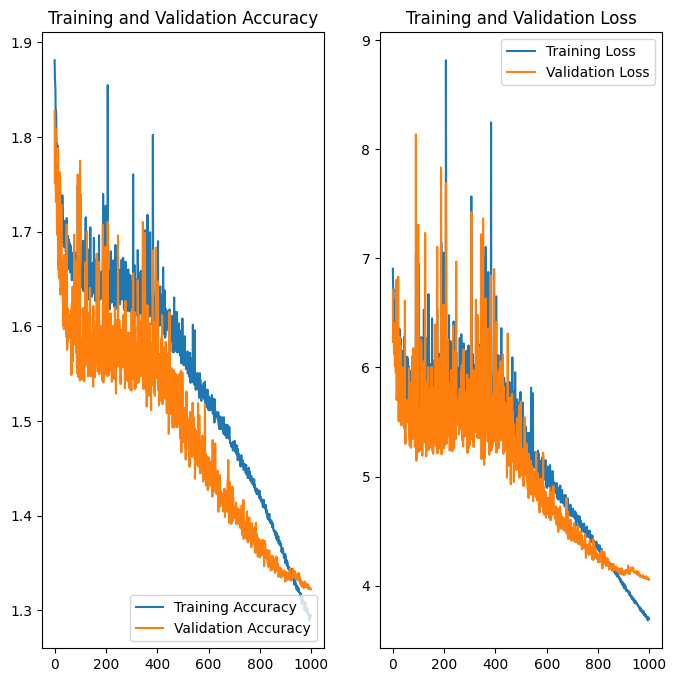

In [32]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [34]:
test_loss, test_acc = model.evaluate(varfval,coefvarfval)

32/32 [==============================] - 0s 3ms/step - loss: 4.0580 - mae: 1.3222


In [37]:
predictions = model.predict(varfval)

32/32 [==============================] - 0s 2ms/step


In [40]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarfval, predictions)

# Calcula la desviación estándar del error
error = coefvarfval - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.3221785780160158, Desviación estándar del error: 1.8974176180229012, Error absoluto máximo: 8.466640591621399


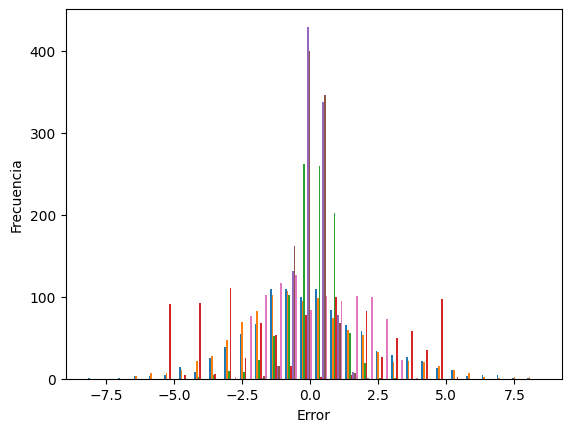

In [41]:
import matplotlib.pyplot as plt

plt.hist(error, bins=30)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [43]:
from sklearn.metrics import r2_score
r2 = r2_score(coefvarfval, predictions)
r2

0.5467851490488782

In [44]:
error_percentile_90 = np.percentile(np.abs(error), 90)
error_percentile_90

3.277085399627686

# Guardamos los datos de Accuracy y Loss

In [45]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 100,200/historyconvtrayec200.csv', index=False)

# Guardamos el modelo

In [46]:
path_to_save = '../../../Modelos/Modelos 100,200/'

In [47]:
model.save(path_to_save + '/convolucionaltr200.h5')

# Importamos el modelo

In [48]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [49]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/convolucionaltr200.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [53]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 200)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[10, 3, 1, 1, 10, 4, 3]
(10, 2, 200)


In [54]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [55]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 12ms/step
[[10.  1.  3.  5. 10.  4.  3.]]


## Graficamos con los coeficientes reales

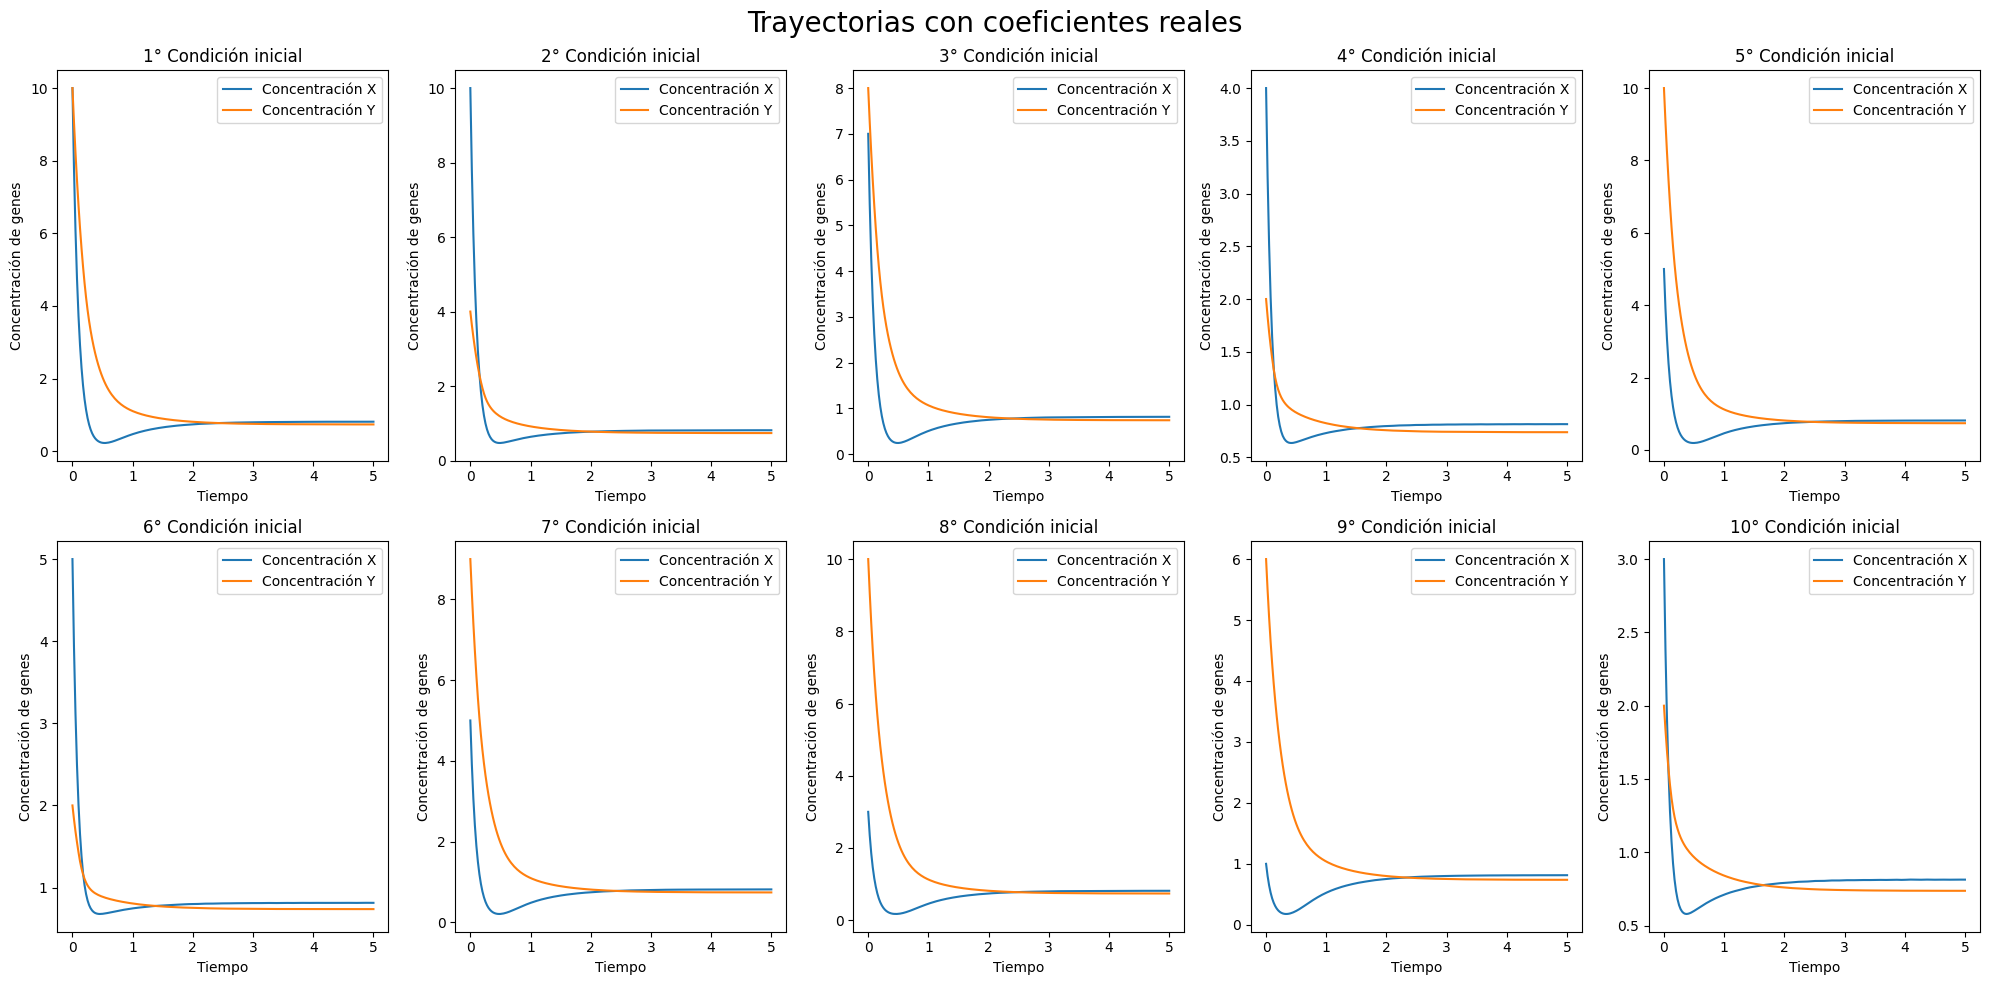

In [56]:
import matplotlib.pyplot as plt

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos con los coeficientes predecidos

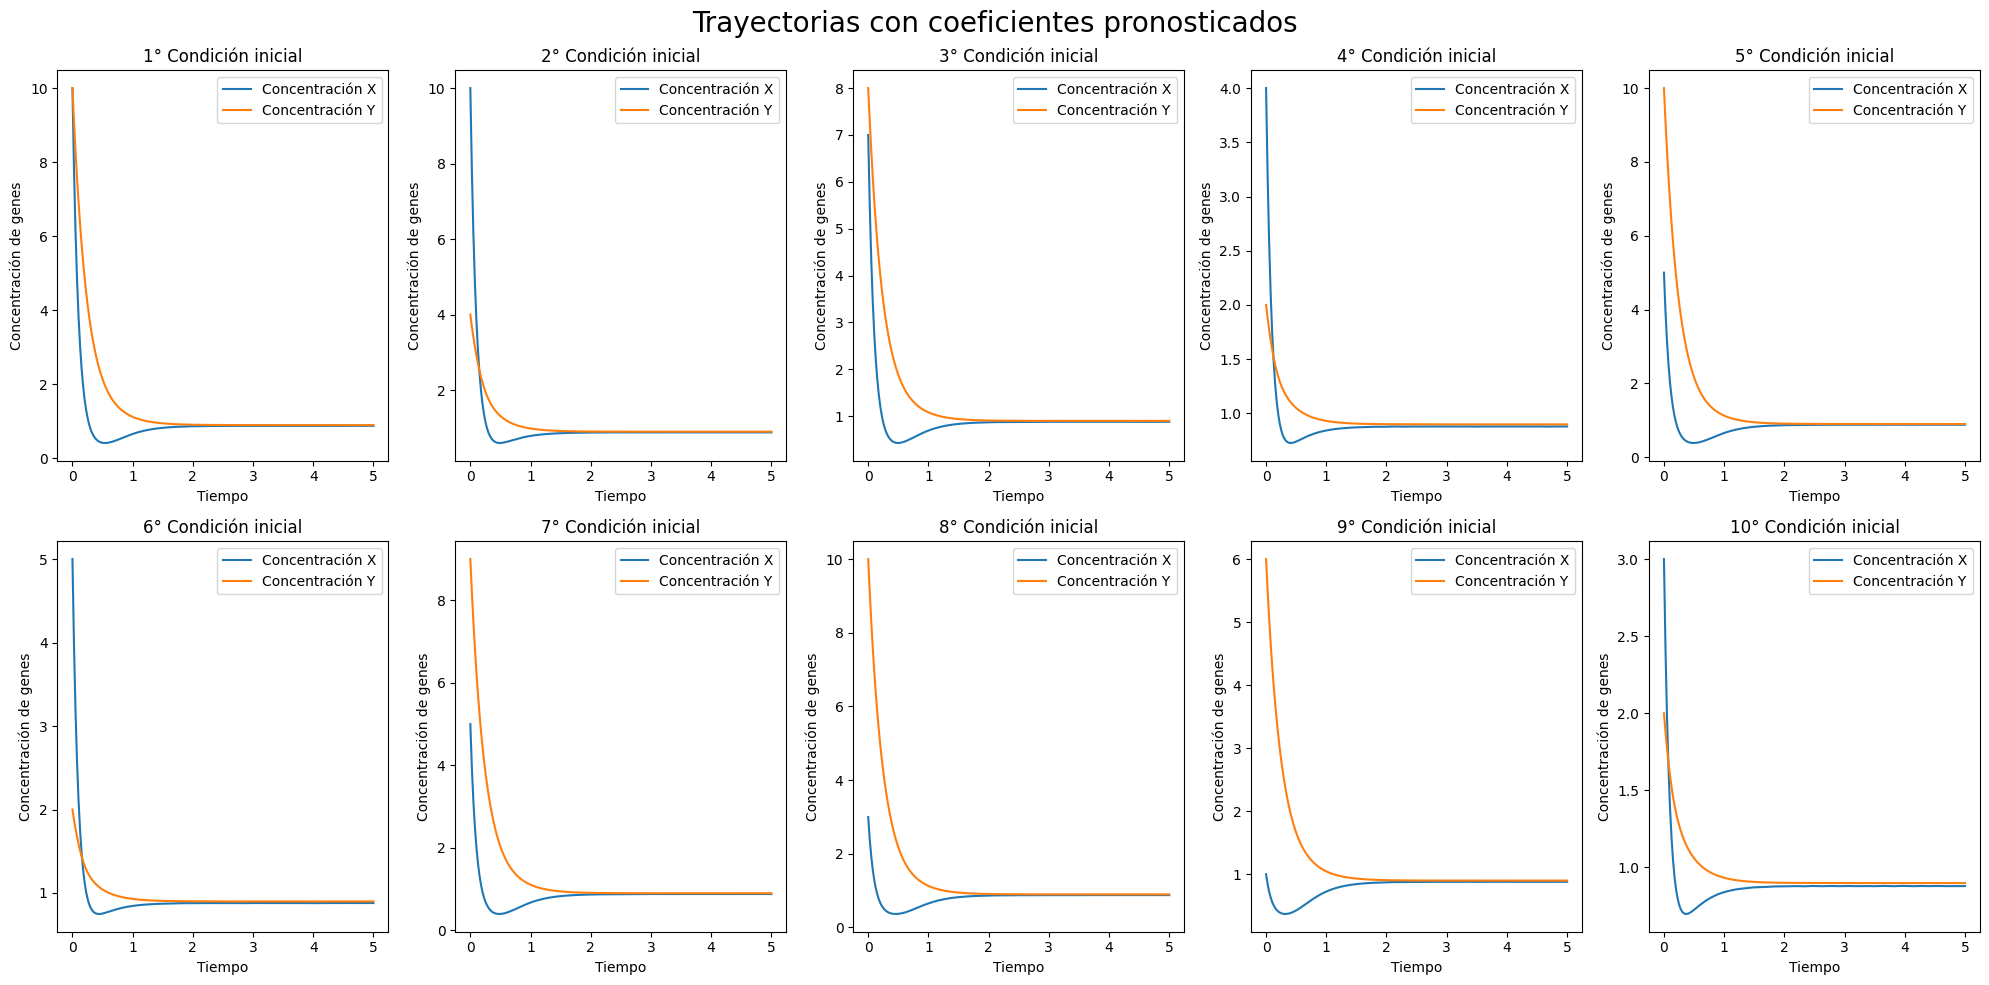

In [57]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

# Graficamos ambos

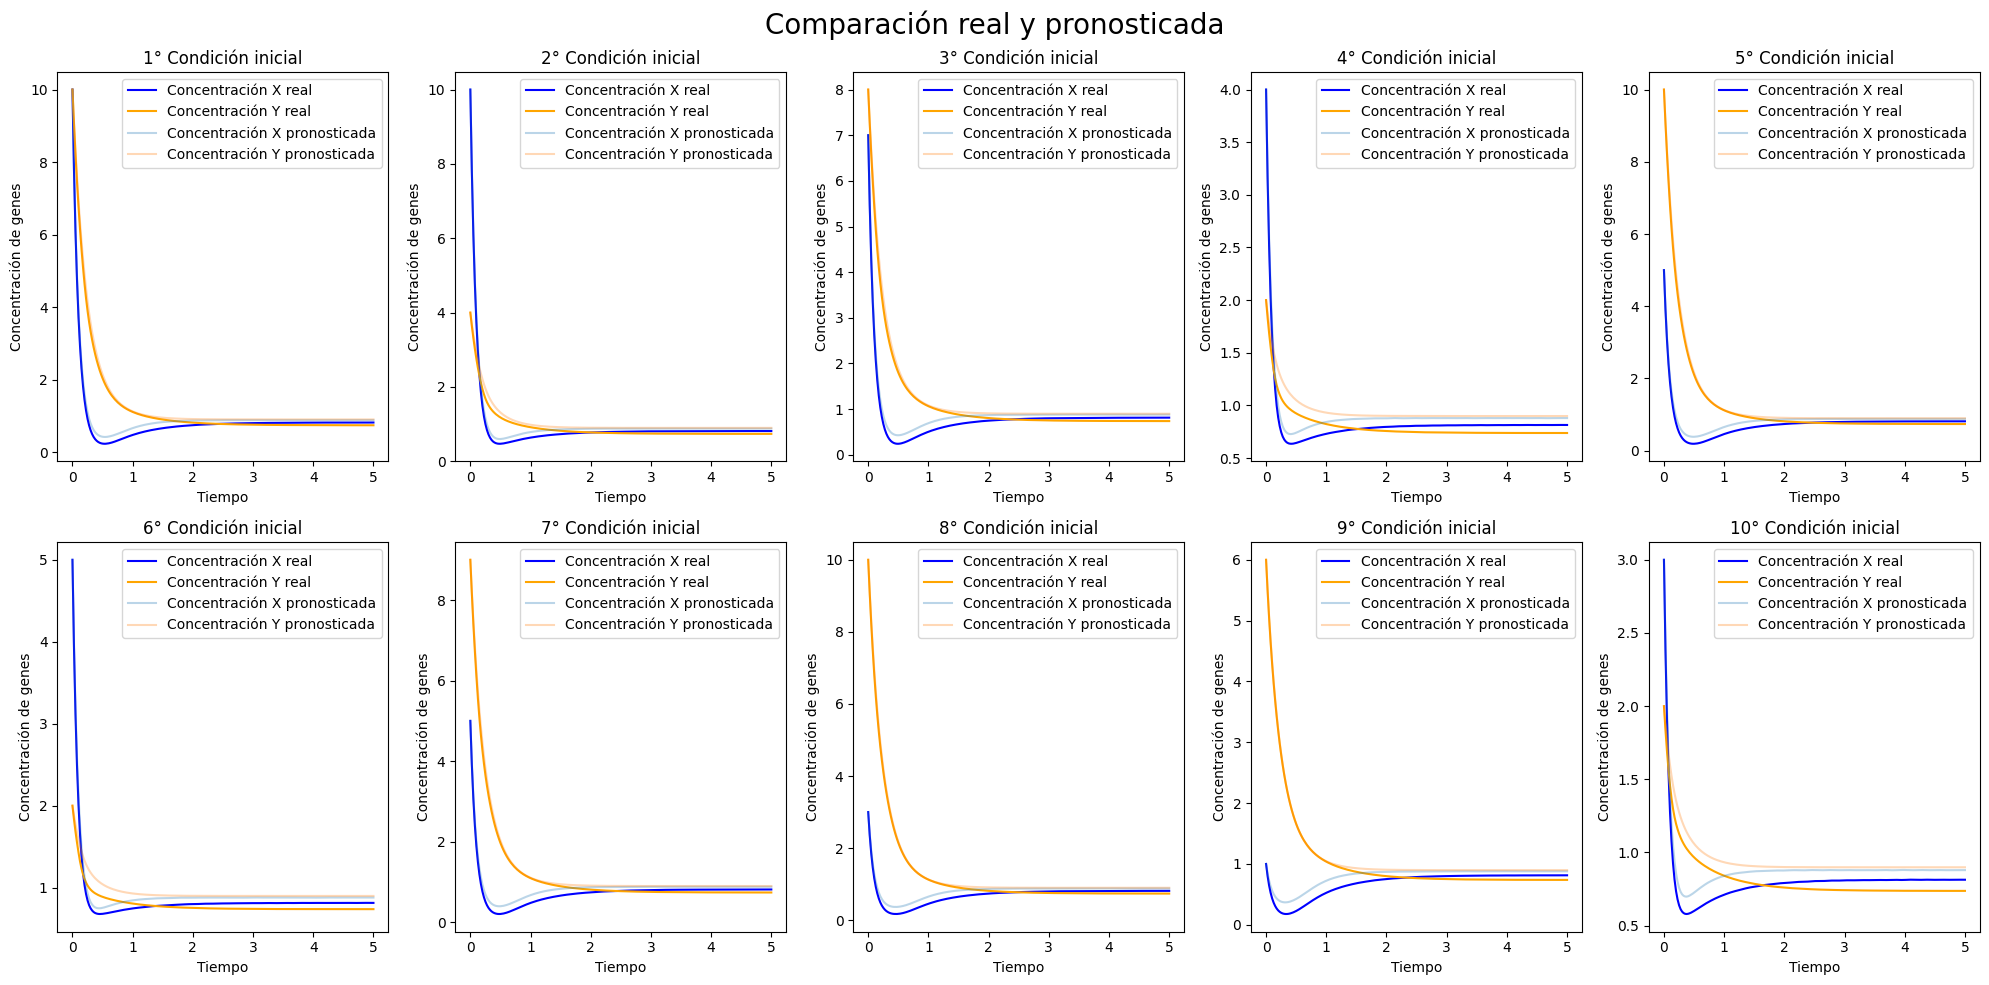

In [58]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

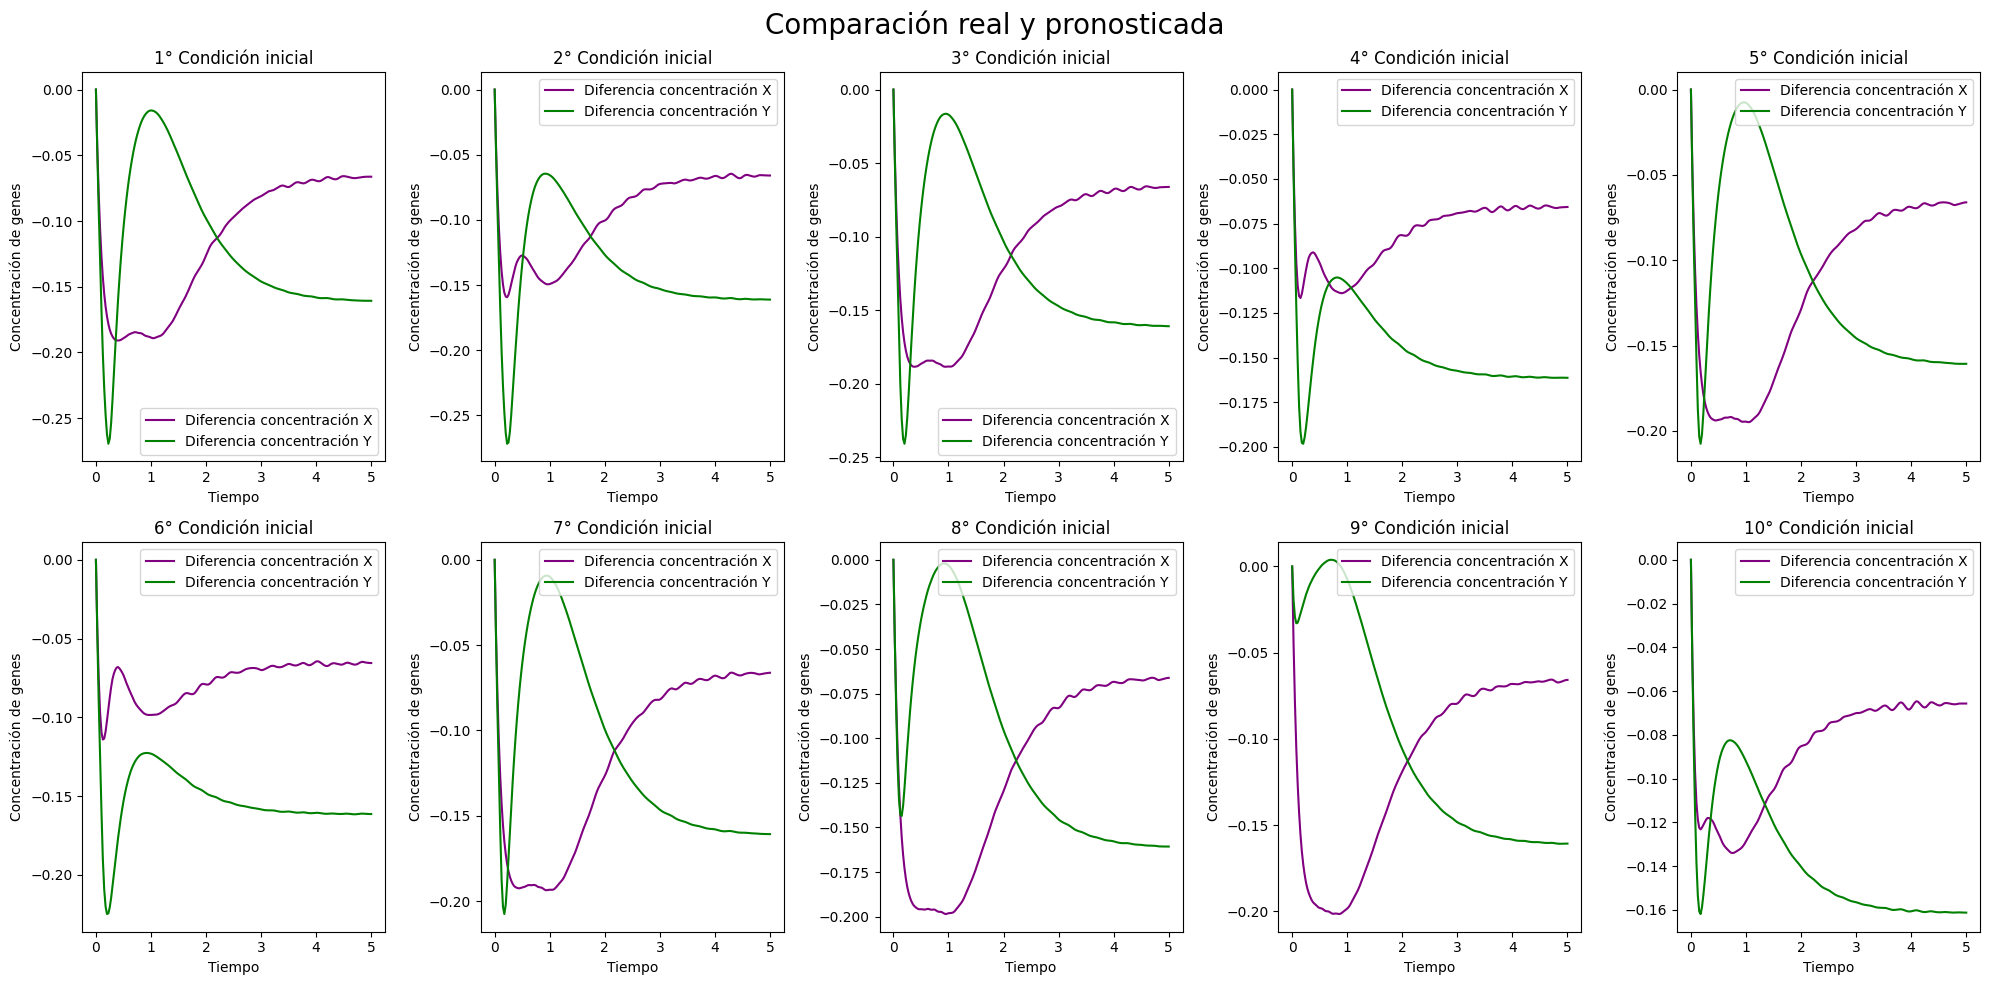

In [59]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [60]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.1031410603481088
0.12491377132565709


# Probamos modelo datos con ruido

## Datos de validación

In [96]:
varfvalrudio = np.load('../../../Base de datos con ruido/Trayectorias 200 eval/varfval.npy')
varfvalrudio = np.transpose(varfvalrudio, (0,3,1,2))

In [97]:
coefvarfvalruido =  np.load('../../../Base de datos con ruido/Trayectorias 200 eval/coefvarfval.npy')

In [98]:
test_lossruido, test_accrudio = model.evaluate(varfvalrudio,coefvarfvalruido)

32/32 [==============================] - 0s 3ms/step - loss: 10.4270 - mae: 2.4542


## Visualización

In [99]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [100]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/convolucionaltr200.h5', custom_objects=custom_objects)

## Creamos datos con ruido

In [107]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.025
N = int(T/dt)

for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 200)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[10, 5, 4, 2, 4, 8, 0]
(10, 2, 200)


In [108]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [109]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 13ms/step
[[5. 4. 1. 5. 2. 5. 3.]]


## Graficamos con los coeficientes reales

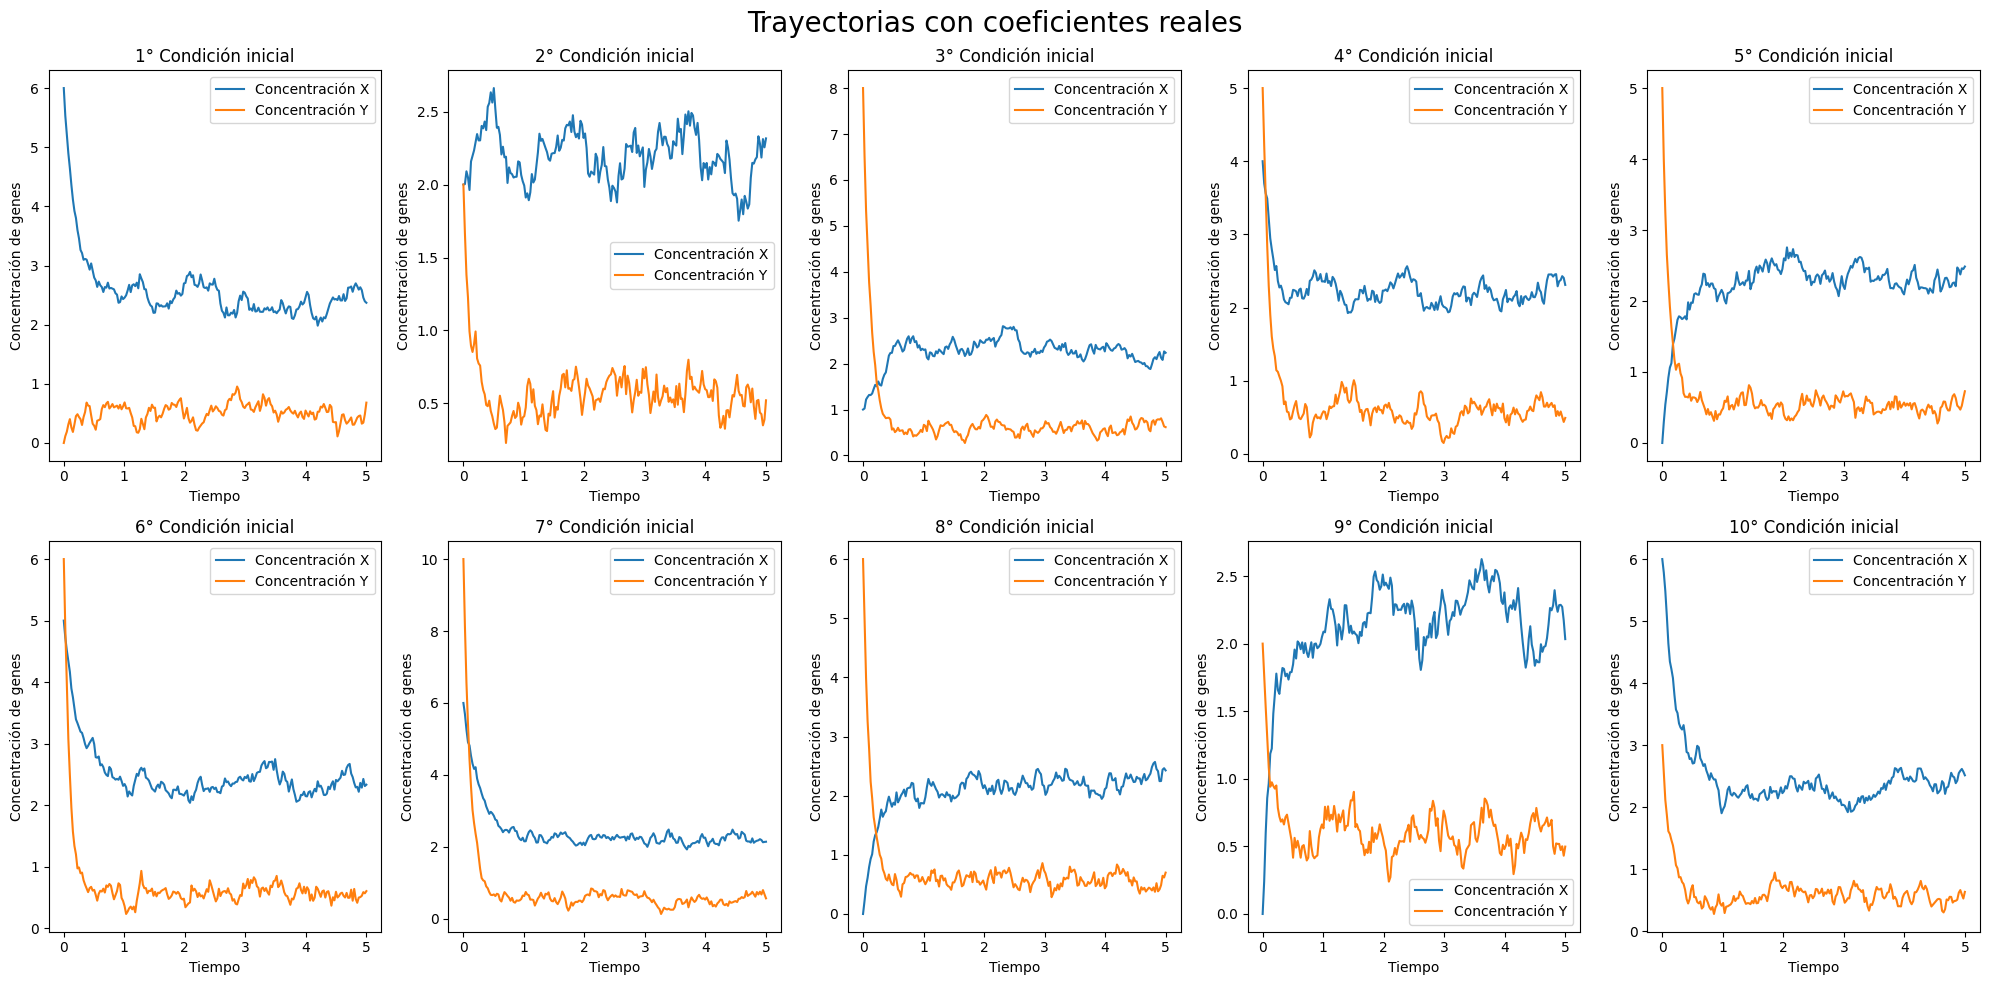

In [110]:
import matplotlib.pyplot as plt

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos con los coeficientes predecidos

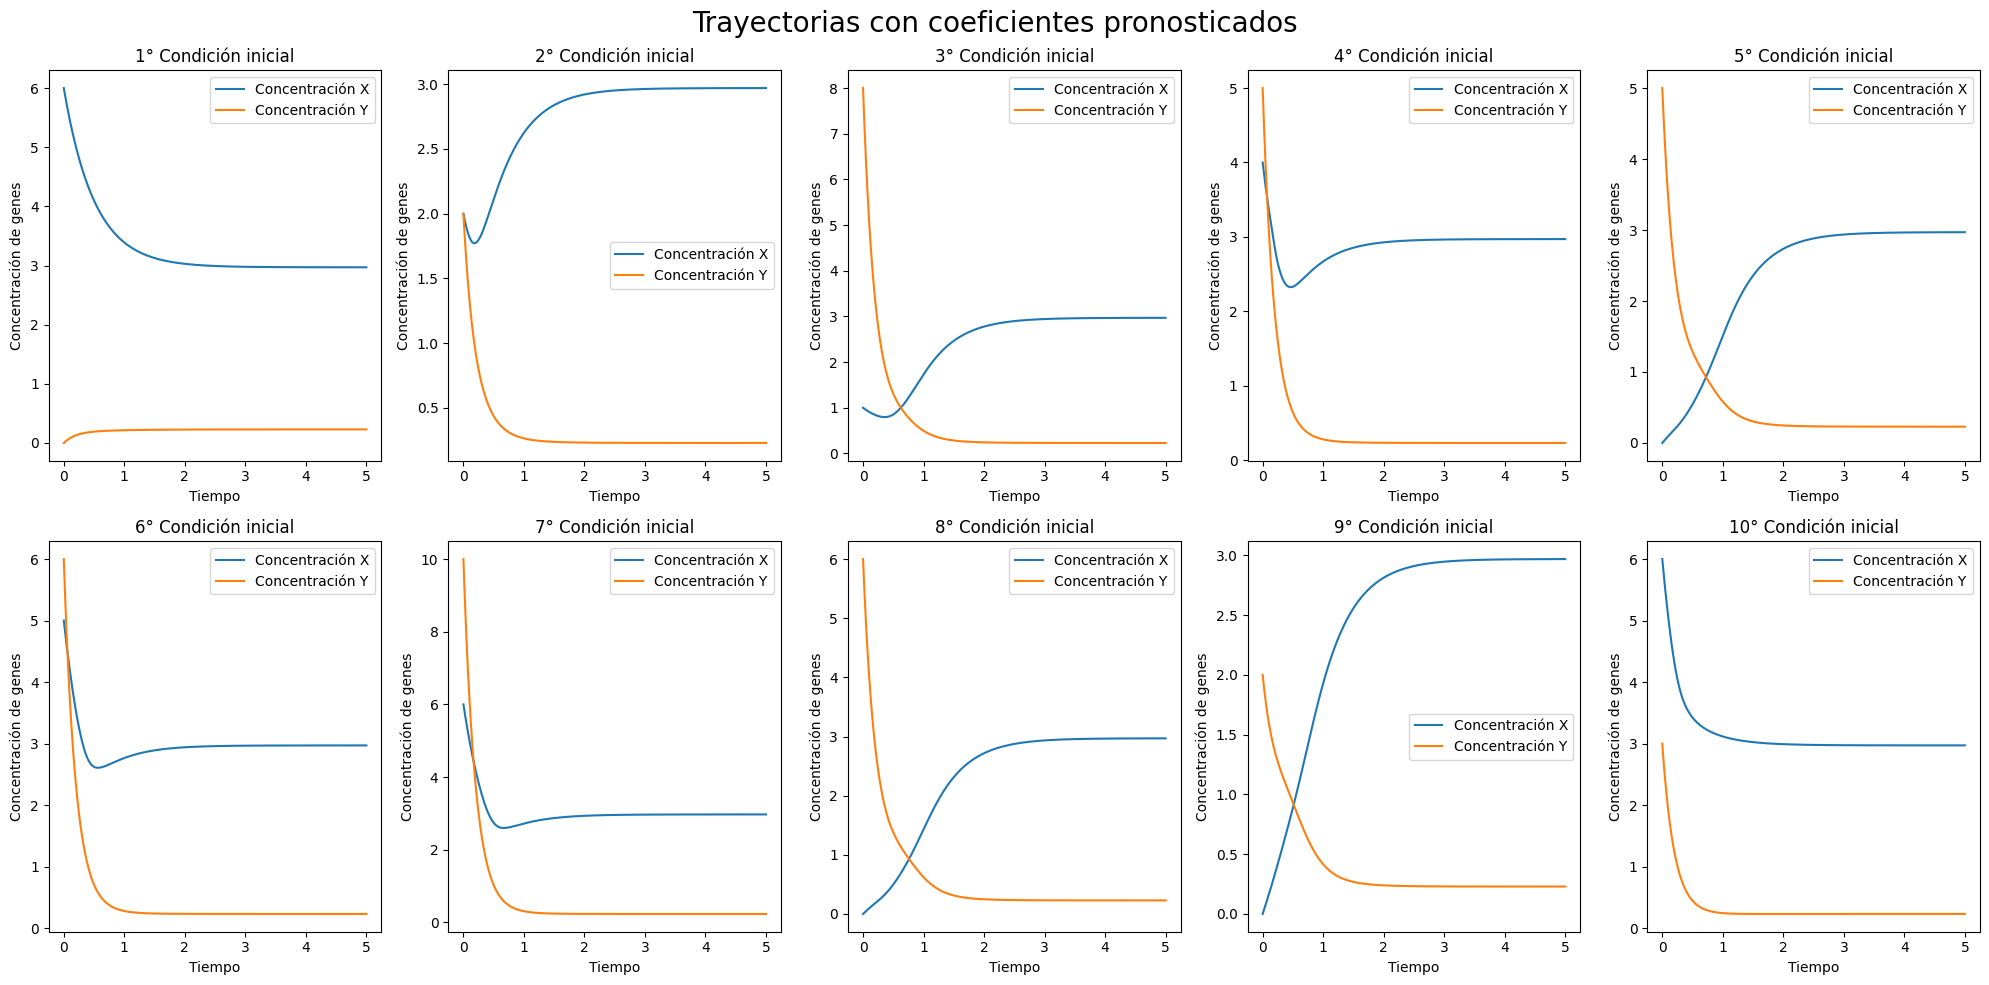

In [111]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

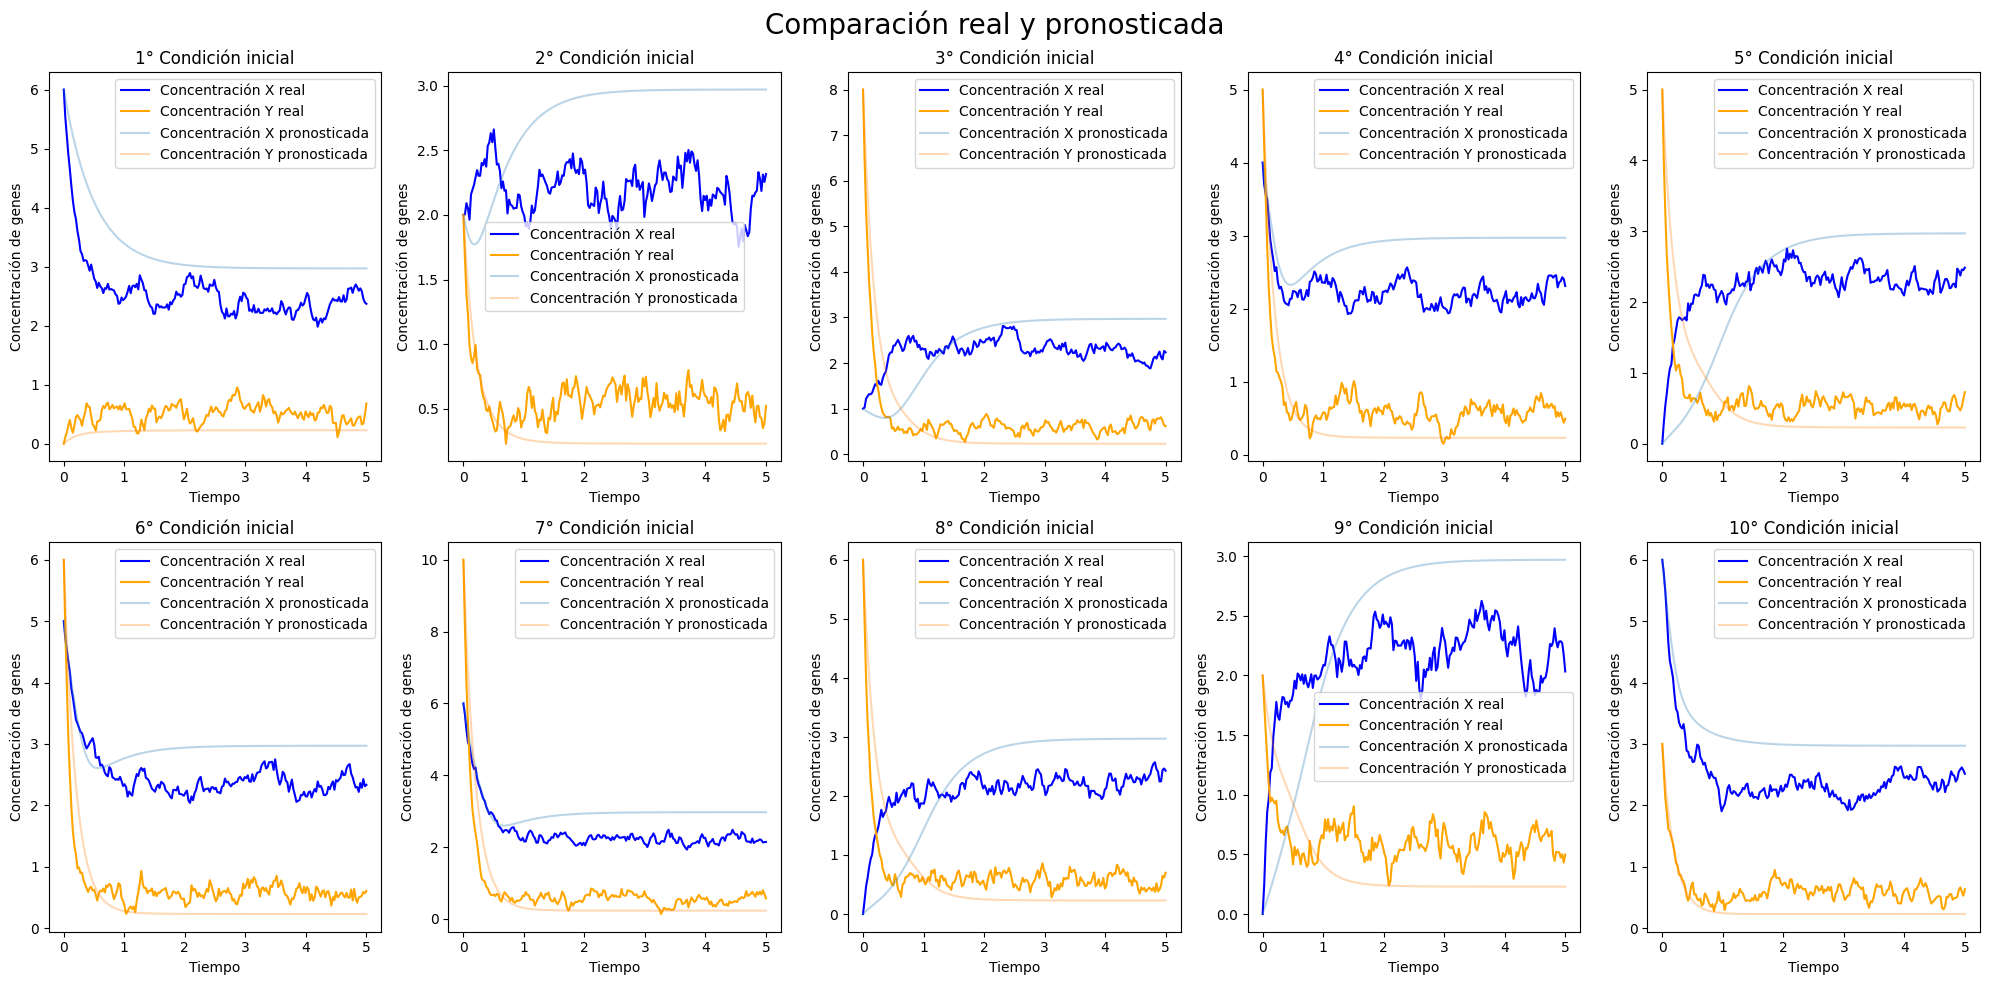

In [112]:
%matplotlib inline
#%matplotlib qt
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

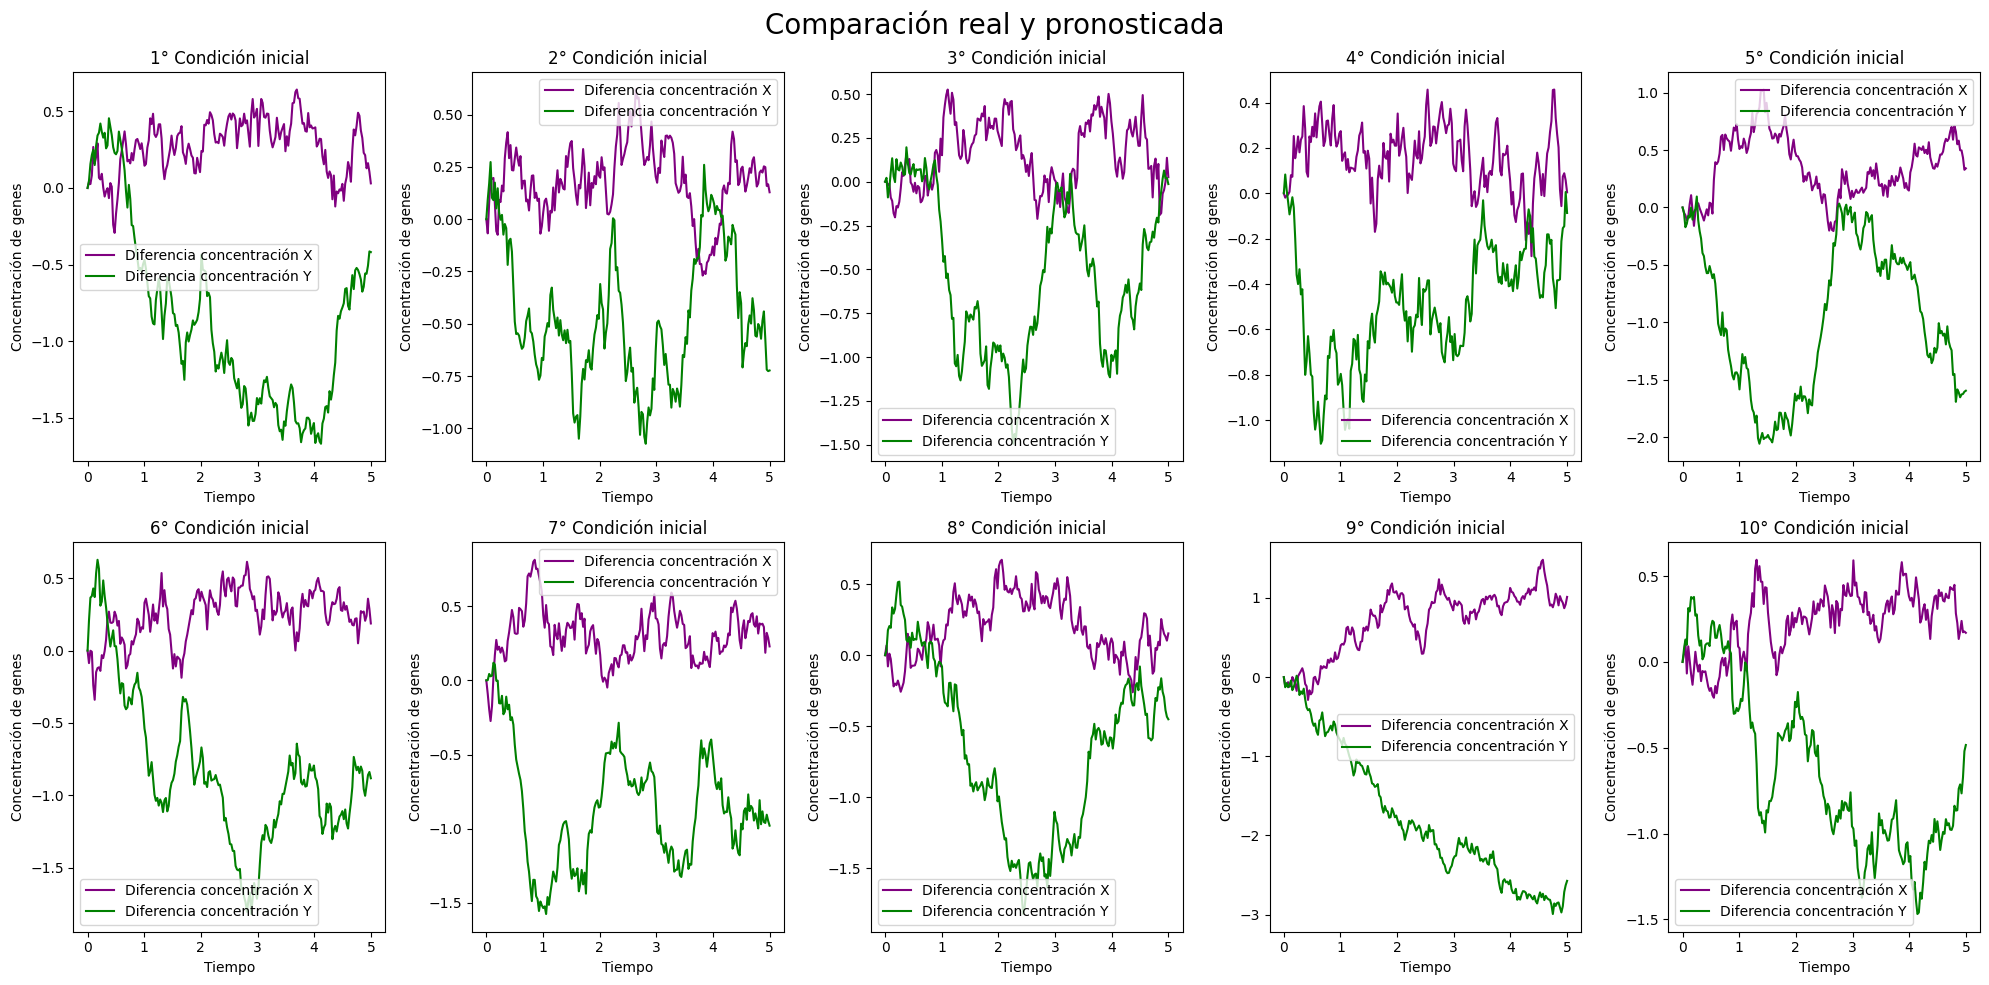

In [69]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [70]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.305233815563299
0.83628762056605
